In [263]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [264]:
torch.set_default_device('cuda')

In [265]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons, regularization_param,
                 regularization_exp, retrain_seed):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()
        self.regularization_param = regularization_param
        # Regularization exponent
        self.regularization_exp = regularization_exp
        # Random seed for weight initialization

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)
        self.retrain_seed = retrain_seed
        # Random Seed for weight initialization
        self.init_xavier()

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # torch.nn.init.xavier_normal_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)

    def regularization(self):
        reg_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                reg_loss = reg_loss + torch.norm(param, self.regularization_exp)
        return self.regularization_param * reg_loss

In [266]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_

        # self.alpha_f = 0.05
        # self.alpha_s = 0.08
        # self.h_f = 5
        # self.h_s = 6
        # self.t_hot = 4
        # self.u_f = 1

        self.t_0 = 293.15

        self.u = torch.tensor([10.0, 0.0]).repeat(n_int, 1)

        self.u_x = np.loadtxt("./formatted_data99/results-99.h5_vel_0.out")
        self.u_y = np.loadtxt("./formatted_data99/results-99.h5_vel_1.out")


        self.rho_l = 998 # Density Fluid

        self.C_f = 4180 # Heat capacity fluid

        self.k_t = 0.598 # Thermal conductivity Fluid
        self.k_b = 149 # Thermal conductivity Solid

        self.H_t = 0.5 * 380e-6 # Half-Thickness Fluid
        self.H_b = 0.5 * 150e-6 # Half-Thickness Solid

        self.h_b = self.k_b / self.H_b
        self.h_t = 35 * self.k_t / (26 * self.H_t)

        self.q_in = 1e5 # heat-source die layer


        applied_pressure = 100000 * 5.0 / 4.0  # kg m^-1 s^-2
        self.L = 0.001  # m
        self.U = np.sqrt(applied_pressure / self.rho_l)  # m/s



        # Extrema of the solution domain (t,x) in [0,0.1]x[-1,1]
        self.domain_extrema = torch.tensor([[0, 1],  # Time dimension
                                            [0, 1]]).to('cuda')  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = 1000

        # F Dense NN to approximate the solution of the PDE

        self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=2,
                                              n_hidden_layers=5,
                                              neurons=64,
                                              regularization_param=0.01,
                                              regularization_exp=2.,
                                              retrain_seed=42).to('cuda')

        # self.approximate_solution = self.approximate_solid

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int = self.assemble_datasets()

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    # Initial condition to solve the heat equation u0(x)=-sin(pi x)
    def initial_condition(self, x):
        return torch.full_like(x, self.t_0)
    
    def interpolate_u(self,input_int):
        input_int = (input_int.detach() * 100).to(int)
        u = torch.zeros((input_int.shape[0], 2))
        for i in range(input_int.shape[0]):
            x = input_int[i, 0]
            y = input_int[i, 1]
            u[i] = torch.tensor([self.u_x[x, y], self.u_y[x, y]])
        return u
    
    def power_map(self, x):

        p = torch.zeros(x.shape[0]) # torch.ones(x.shape[0]) * self.q_in

        x_crit = torch.bitwise_and(0.15 < x[:, 1], x[:, 1] < 0.65)
        x_crit2= torch.bitwise_and(0.35 < x[:, 1], x[:, 1] < 0.45)
        
        y_crit = torch.bitwise_and(0.3 < x[:, 0], x[:, 0] < 0.55)
        y_crit2 = torch.bitwise_and(0.7 < x[:, 0], x[:, 0] < 0.9)

        crit = torch.bitwise_and(x_crit, y_crit)
        crit2= torch.bitwise_and(x_crit2, y_crit2)

        p[torch.bitwise_or(crit, crit2)] = self.q_in
        return p #torch.full_like(x, self.q_in)

    def velocity(self, x):
        p = torch.clone(x)



        return p

    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_inoutflow_boundary_points(self):
        t0 = self.domain_extrema[1, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb).to('cuda'))
        input_tb[:, 1] = torch.full(input_tb[:, 1].shape, t0)
        output_tb = self.initial_condition(input_tb[:, 0]).reshape(-1, 1)

        return input_tb, output_tb

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_wall_boundary_points(self):
        x0 = self.domain_extrema[0, 0]
        xL = self.domain_extrema[0, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb).to('cuda'))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 0] = torch.full(input_sb_0[:, 0].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 0] = torch.full(input_sb_L[:, 0].shape, xL)

        return input_sb_0, input_sb_L

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int).to('cuda'))
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb_0, input_sb_L = self.add_wall_boundary_points()   # S_sb
        input_tb, output_tb = self.add_inoutflow_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()         # S_int

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb_0, input_sb_L), batch_size=2*self.space_dimensions*self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        output_tb = self.approximate_solution(input_tb)
        output_tb_s = output_tb[:, 0]
        output_tb_f = output_tb[:, 1]

        return output_tb_s, output_tb_f

    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True

        t = self.approximate_solution(input_int)

        ts = t[:, 0]
        tf = t[:, 1]

        grad_ts = torch.autograd.grad(ts.sum(), input_int, create_graph=True)[0]
        grad_ts_y = grad_ts[:, 1]
        grad_ts_yy = torch.autograd.grad(grad_ts_y.sum(), input_int, create_graph=True)[0][:, 1]

        grad_ts_x = grad_ts[:, 0]
        grad_ts_xx = torch.autograd.grad(grad_ts_x.sum(), input_int, create_graph=True)[0][:, 0]

        grad_tf = torch.autograd.grad(tf.sum(), input_int, create_graph=True)[0]
        grad_tf_y = grad_tf[:, 1]
        grad_tf_yy = torch.autograd.grad(grad_tf_y.sum(), input_int, create_graph=True)[0][:, 1]

        grad_tf_x = grad_tf[:, 0]
        grad_tf_xx = torch.autograd.grad(grad_tf_x.sum(), input_int, create_graph=True)[0][:, 0]

        div_grad_tf = grad_tf_xx + grad_tf_yy
        div_grad_ts = grad_ts_xx + grad_ts_yy


        u_grad_t = torch.inner(self.interpolate_u(input_int), grad_tf)

        termA = 2/3 * self.rho_l * self.C_f * self.U / self.L * u_grad_t
        termB = - 49/self.L**2 * self.k_t / 52 * div_grad_tf
        termC =  - 1 / (2 * self.H_t) * self.h_b * self.h_t / (self.h_b + self.h_t)*(ts - tf)

        termD = -1/self.L**2 * self.k_b/2 * div_grad_ts
        termE = 1 / (2 * self.H_b) * self.h_b * self.h_t / (self.h_b + self.h_t)*(ts - tf)
        termF = - 1 / (2 * self.H_b) * self.power_map(input_int) #self.q_in
        
        # print("A", termA.shape, "B", termB.shape, "C", termC.shape)

        # print(torch.isfinite(termA), torch.isfinite(termB), torch.isfinite(termC))
        # print(torch.isnan(termD), torch.isnan(termE), torch.isnan(termF))

    
        print("res1", torch.mean((termA)**2))
        print("res2", torch.mean((termB)**2))

        residual = (termA + termB + termC)**2
        residual += (termD + termE + termF)**2

        # print("Res", residual)

        return residual.reshape(-1, )

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb_0, inp_train_sb_L, inp_train_tb, sol_tb, inp_train_int, verbose=True):

        pred_tb_solid, pred_tb_fluid = self.apply_initial_condition(inp_train_tb)

        inp_train_sb_0.requires_grad = True
        inp_train_sb_L.requires_grad = True

        t_0 = self.approximate_solution(inp_train_sb_0)

        t_L = self.approximate_solution(inp_train_sb_L)

        loss_sb = torch.mean(t_0**2 + t_L**2)

        loss_tb = 100 * torch.mean((pred_tb_fluid - sol_tb)**2)

        loss_int = 0.00000000001 * torch.mean(self.compute_pde_residual(inp_train_int)) # 

        loss_u = loss_sb + loss_tb
        print("Loss sb", round(loss_sb.item(), 4), "loss tb", round(loss_tb.item(), 4))

        loss_reg = self.approximate_solution.regularization()

        loss = torch.log10(self.lambda_u * loss_u + loss_int + loss_reg)
        if verbose: print("Total loss: ", round(loss.item(), 4), "| Boundary Error: ", round(loss_u.item(), 4), "| Interior Error: ", round(loss_int.item(), 4) , "| Regularization Error: ", round(loss_reg.item(), 4))

        return loss

    ################################################################################################
    def     fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb_0, inp_train_sb_L), (inp_train_tb, sol_tb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb_0, inp_train_sb_L, inp_train_tb, sol_tb, inp_train_int, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history



In [267]:
n_int = 1024
n_sb = 64
n_tb = 64

pinn = Pinns(n_int, n_sb, n_tb)

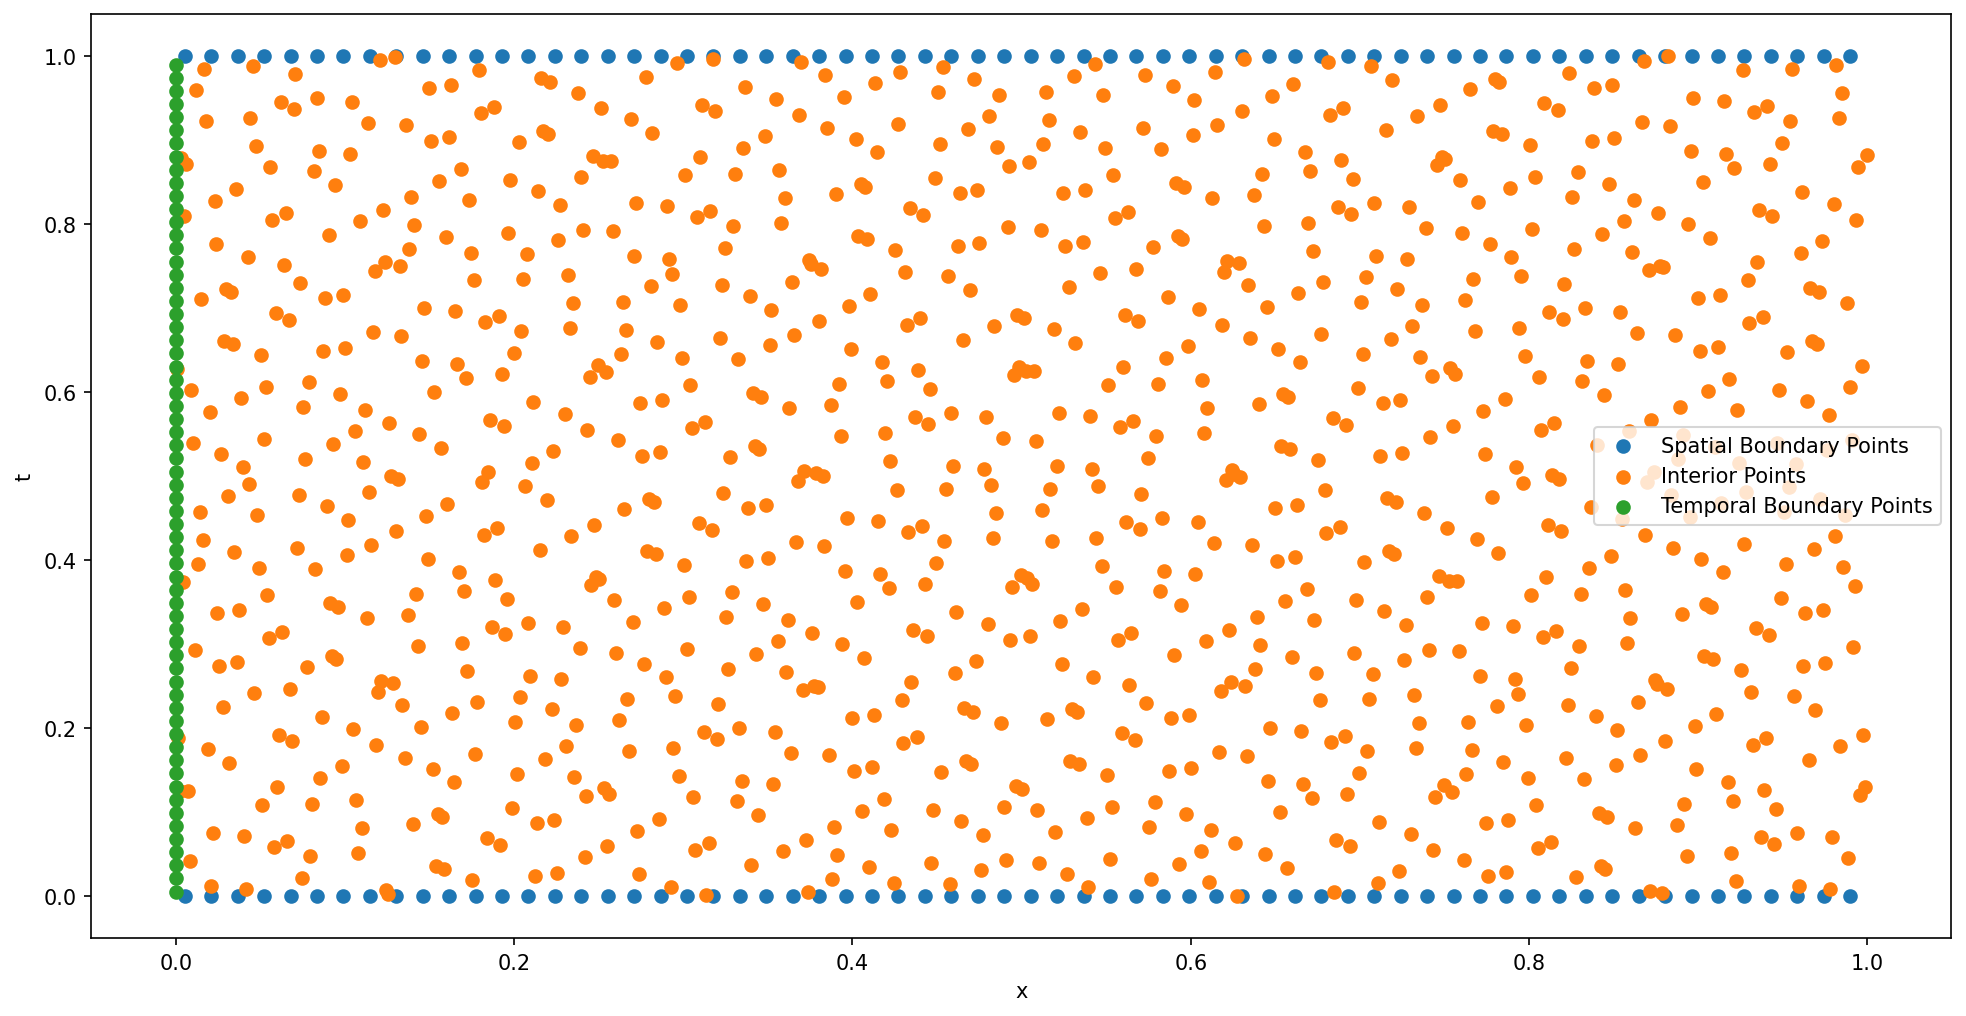

In [268]:
# Plot the input training points
input_sb_, output_sb_ = pinn.add_wall_boundary_points()
input_tb_, output_tb_ = pinn.add_inoutflow_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()

plt.figure(figsize=(16, 8), dpi=150)
plt.scatter(torch.cat([input_sb_, output_sb_], 0)[:, 1].detach().cpu().numpy(), torch.cat([input_sb_, output_sb_], 0)[:, 0].detach().cpu().numpy(), label="Spatial Boundary Points")
plt.scatter(input_int_[:, 1].detach().cpu().numpy(), input_int_[:, 0].detach().cpu().numpy(), label="Interior Points")
plt.scatter(input_tb_[:, 1].detach().cpu().numpy(), input_tb_[:, 0].detach().cpu().numpy(), label="Temporal Boundary Points")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

In [269]:
n_epochs = 10
optimizer_LBFGS = optim.LBFGS(pinn.approximate_solution.parameters(),
                              lr=float(0.5),
                              max_iter=50000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)

optimizer_ADAM = optim.Adam(pinn.approximate_solution.parameters(),
                            lr=float(0.001))


hist = pinn.fit(num_epochs=n_epochs,
                optimizer=optimizer_LBFGS,
                verbose=True)

################################  0  ################################
res1 tensor(3.7926e+23, device='cuda:0', grad_fn=<MeanBackward0>)
res2 tensor(6.2034e+13, device='cuda:0', grad_fn=<MeanBackward0>)
Loss sb 2.6376 loss tb 8523541.0
Total loss:  12.5799 | Boundary Error:  8523544.0 | Interior Error:  3792682352640.0 | Regularization Error:  0.5973
################################  1  ################################
res1 tensor(5.7756e+22, device='cuda:0', grad_fn=<MeanBackward0>)
res2 tensor(2.6520e+13, device='cuda:0', grad_fn=<MeanBackward0>)
Loss sb 1.7382 loss tb 8569672.0
Total loss:  11.768 | Boundary Error:  8569674.0 | Interior Error:  577565360128.0 | Regularization Error:  0.5972
################################  2  ################################
res1 tensor(1.1085e+23, device='cuda:0', grad_fn=<MeanBackward0>)
res2 tensor(1.2483e+13, device='cuda:0', grad_fn=<MeanBackward0>)
Loss sb 2.0162 loss tb 8611313.0
Total loss:  12.0481 | Boundary Error:  8611315.0 | Interior Er

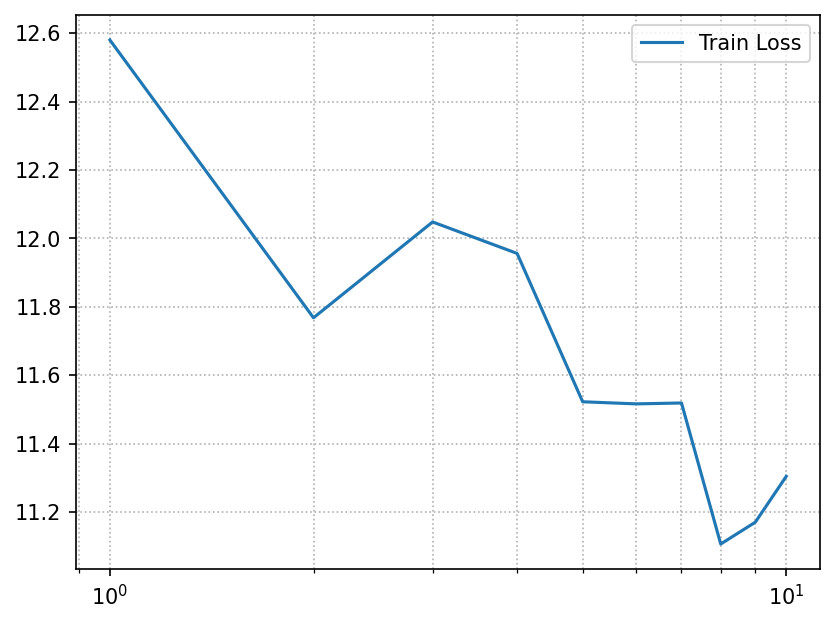

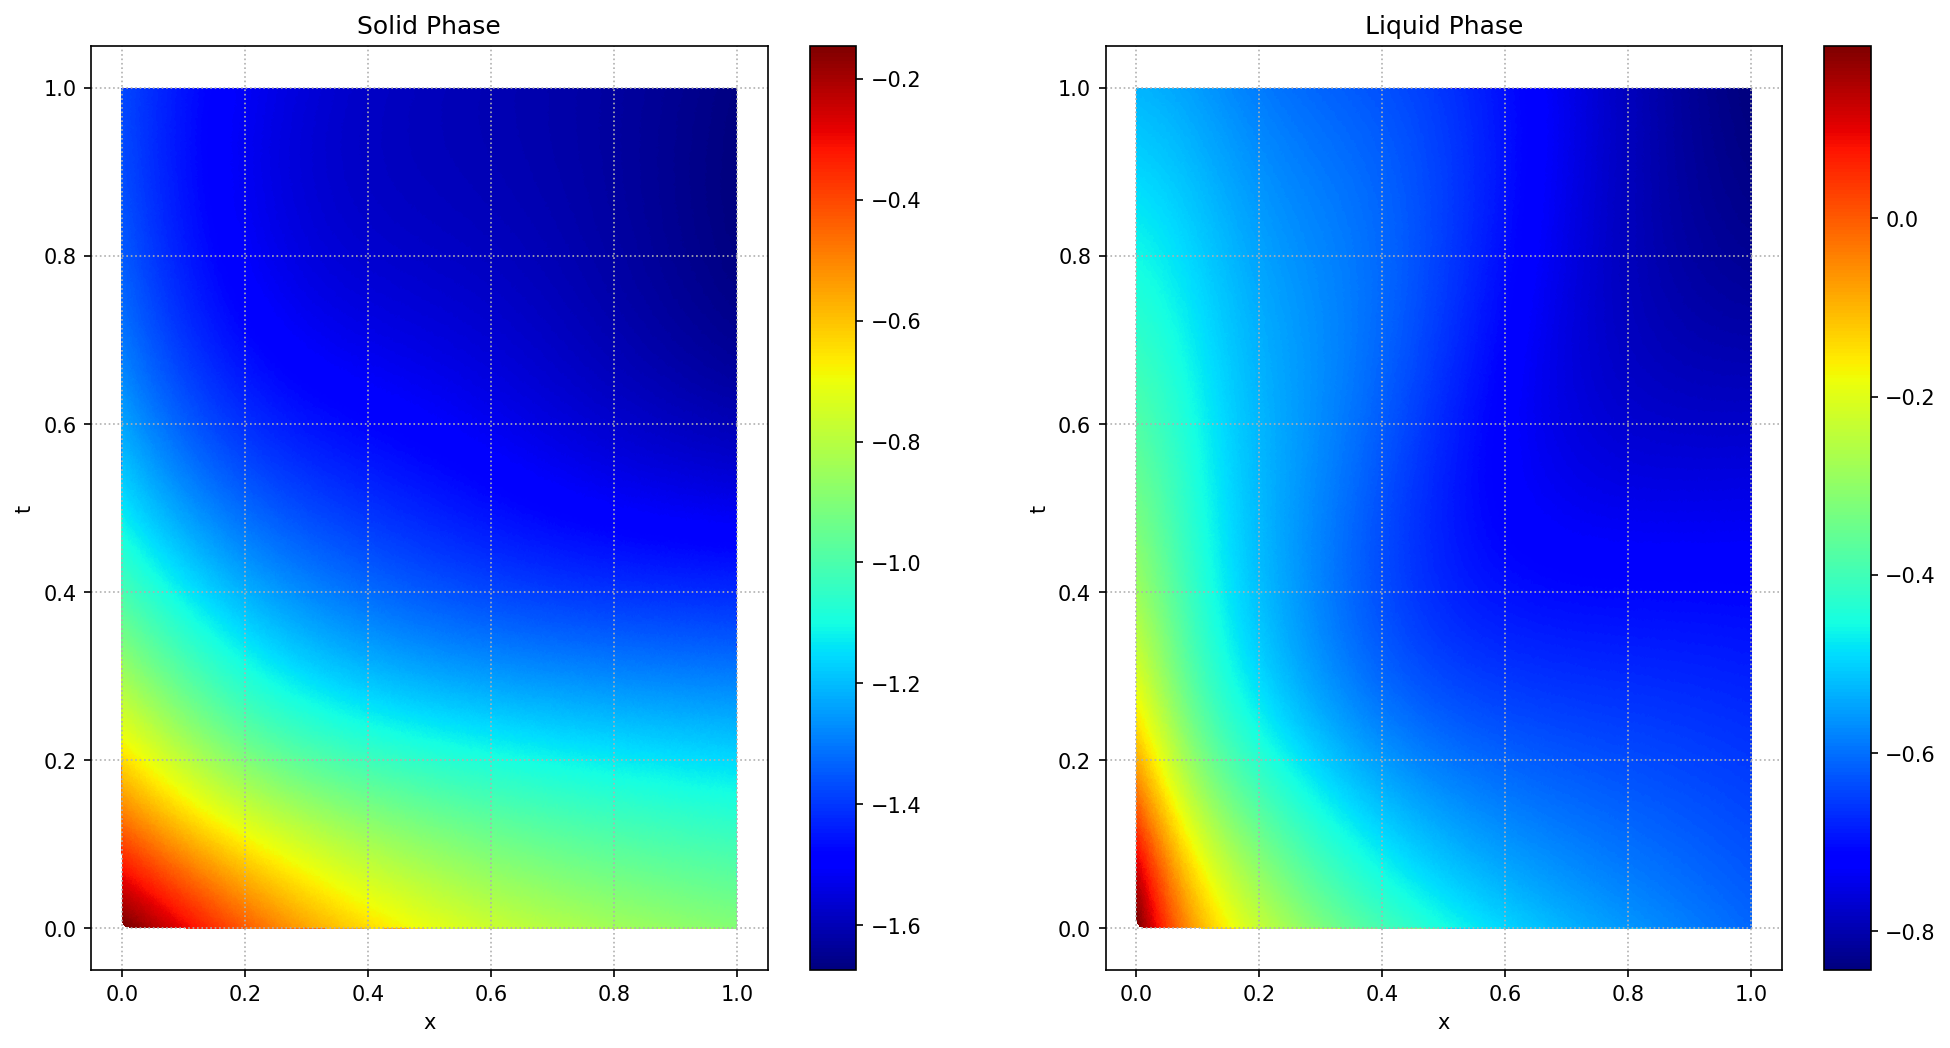

In [270]:
plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

inputs = pinn.convert(pinn.soboleng.draw(100000).to('cuda'))

pred = pinn.approximate_solution(inputs)

solid = pred[:, 0]
liquid = pred[:, 1]

solid = solid.reshape(-1, )
liquid = liquid.reshape(-1, )

fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
im1 = axs[0].tripcolor(inputs[:, 1].detach().cpu(), inputs[:, 0].detach().cpu(), solid.detach().cpu(), cmap="jet")
axs[0].set_xlabel("x")
axs[0].set_ylabel("t")
plt.colorbar(im1, ax=axs[0])
axs[0].grid(True, which="both", ls=":")
axs[0].set_title("Solid Phase")

im2 = axs[1].tripcolor(inputs[:, 1].detach().cpu(), inputs[:, 0].detach().cpu(), liquid.detach().cpu(), cmap="jet")
axs[1].set_xlabel("x")
axs[1].set_ylabel("t")
plt.colorbar(im2, ax=axs[1])
axs[1].grid(True, which="both", ls=":")
axs[1].set_title("Liquid Phase")

plt.show()


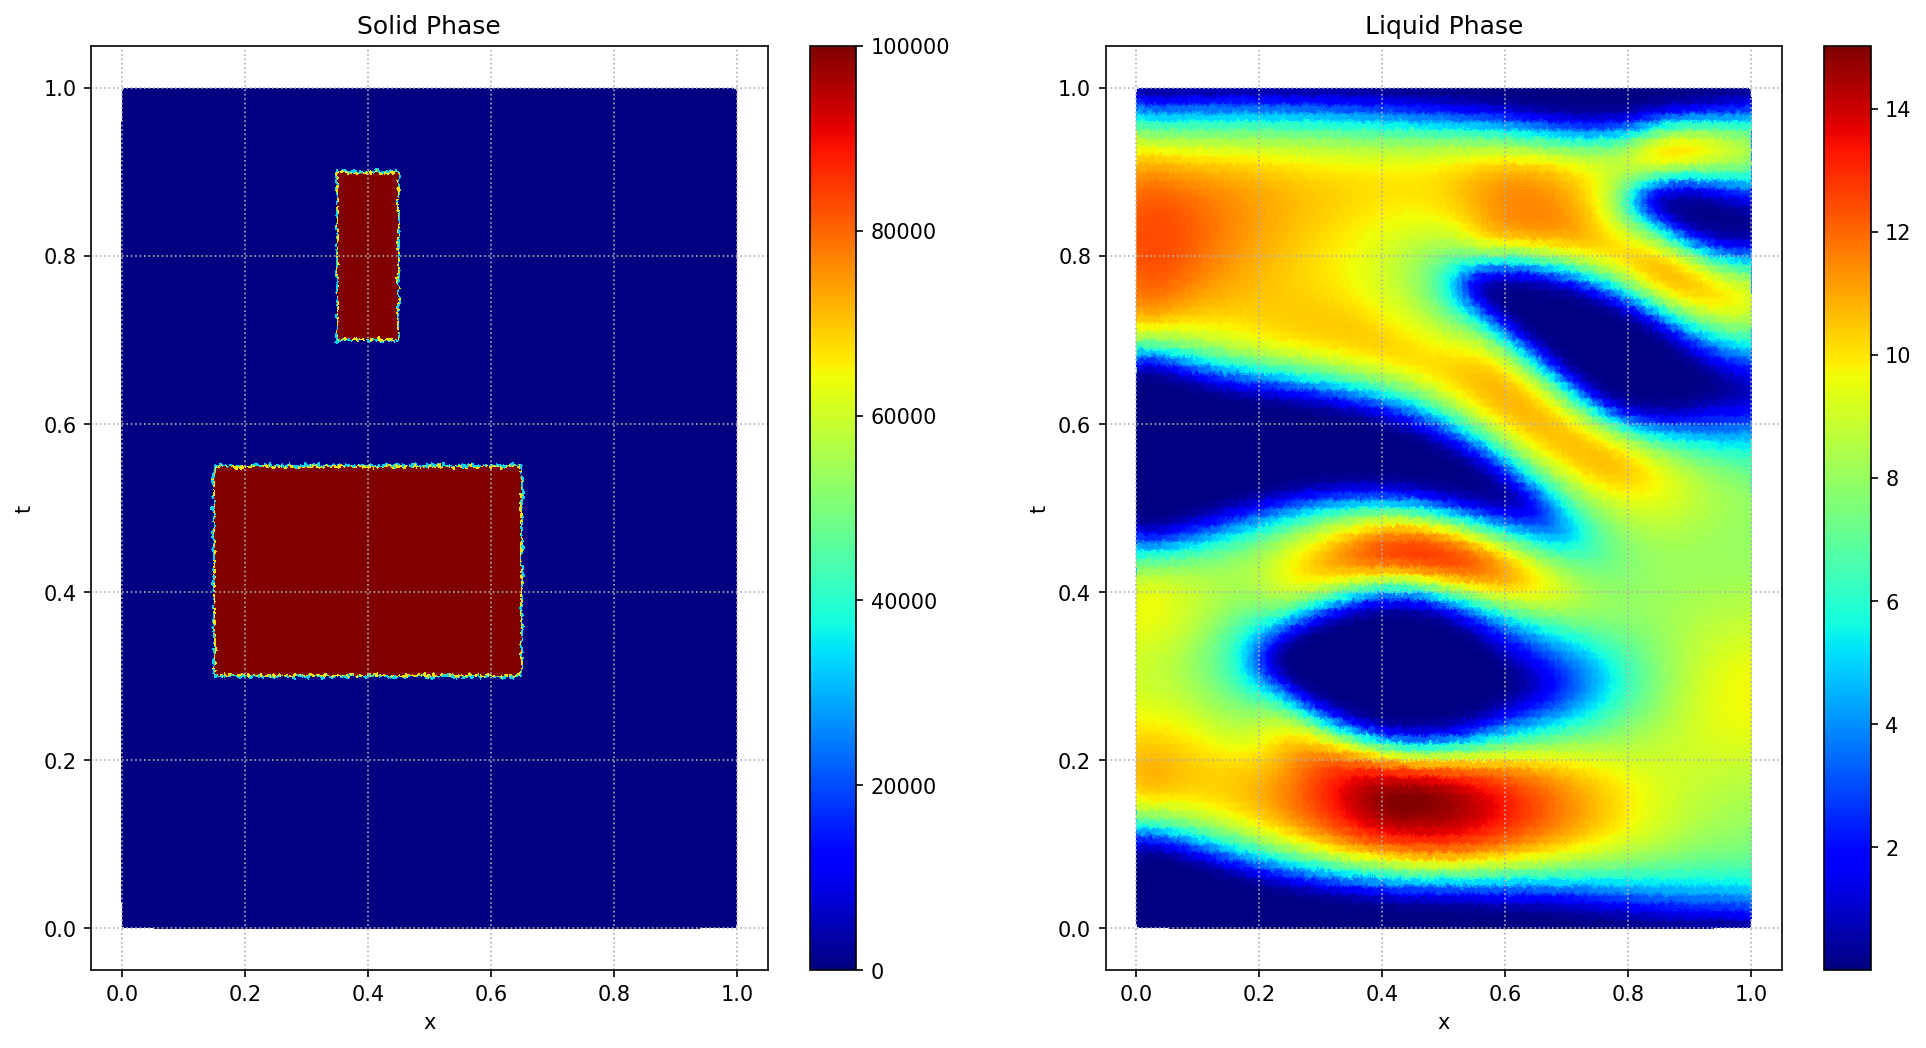

In [271]:

inputs = pinn.convert(pinn.soboleng.draw(100000).to('cuda'))

power_map = pinn.power_map(inputs)
u_x = pinn.interpolate_u(inputs)[:, 0]

fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
im1 = axs[0].tripcolor(inputs[:, 1].detach().cpu(), inputs[:, 0].detach().cpu(), power_map.detach().cpu(), cmap="jet")
axs[0].set_xlabel("x")
axs[0].set_ylabel("t")
plt.colorbar(im1, ax=axs[0])
axs[0].grid(True, which="both", ls=":")
axs[0].set_title("Solid Phase")

im2 = axs[1].tripcolor(inputs[:, 1].detach().cpu(), inputs[:, 0].detach().cpu(), u_x.detach().cpu(), cmap="jet")
axs[1].set_xlabel("x")
axs[1].set_ylabel("t")
plt.colorbar(im2, ax=axs[1])
axs[1].grid(True, which="both", ls=":")
axs[1].set_title("Liquid Phase")

plt.show()
